<a href="https://colab.research.google.com/github/Osmayda/Modeling/blob/main/Healthcare_Stroke_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Healthcare Stroke Prediction**

#**Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

## Models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression

## Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

# Filter ALL Warnings
import warnings
warnings.filterwarnings('ignore')

## **1. Load and inspect the data**

In [3]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the data
filename ="/content/drive/MyDrive/Coding Dojo/Stack 2 Intro to Machine Learning/Week 7/dataset/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(filename)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- The data loaded correctly.

In [6]:
# Display the number of rows and columns for the dataframe
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 5110 rows, and 12 columns.
The rows represent 5110 observations, and the columns represent 11 features and 1 target variable.


## **2. Clean the Data**

In [7]:
# Display the column names, count of non-null values, and their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### **Remove Unnecessary Columns**

- Removing id as it is not useful for predicting. 

In [10]:
# Removing unnecessary columns
df.drop(columns = 'id', inplace = True)
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

- Confirmed, the column has been dropped. 

### **Remove Unecessary Rows**

### **Duplicates**

In [11]:
# Display the number of duplicate rows in the dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


### **Missing Values**

In [12]:
# Display the total number of missing values
print(f'There are {df.isna().sum().sum()} missing values.')

There are 201 missing values.


In [13]:
# Check for missing values. You should produce an output that shows the number of missing values for each feature.
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [14]:
# missing values as percentage
round((df.isna().sum() / len(df)) * 100, 2)

gender               0.00
age                  0.00
hypertension         0.00
heart_disease        0.00
ever_married         0.00
work_type            0.00
Residence_type       0.00
avg_glucose_level    0.00
bmi                  3.93
smoking_status       0.00
stroke               0.00
dtype: float64

- Never impute values prior to Train_Test_Split, as it would cause data leakage. 
- Missing values will be imputed after Train_Test_Split.

In [22]:
# Check for and address values in numerical columns. 
df.describe(include='number')

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- The min for age is .08 which appears to be an impossible number. 

In [32]:
# age of 0.08
df[df['age'] == 0.08]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1614,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3295,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0


- Only 2 samples, correctly attributed as 'children'. 

In [33]:
# Check for and address values in categorical columns. 
df.describe(include='object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


## **Insconsistencies in 'object' categories**

In [34]:
# Check for discrepancies in categorical data
for i in df.dtypes[df.dtypes == 'object'].index:
  print(f'{i} ---')
  print(df[i].unique())
  print('')

gender ---
['Male' 'Female' 'Other']

ever_married ---
['Yes' 'No']

work_type ---
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Residence_type ---
['Urban' 'Rural']

smoking_status ---
['formerly smoked' 'never smoked' 'smokes' 'Unknown']



In [35]:
for i in df.dtypes[df.dtypes == 'object'].index:
  print(f'{i} ---')
  print(df[i].value_counts())
  print('')

gender ---
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

ever_married ---
Yes    3353
No     1757
Name: ever_married, dtype: int64

work_type ---
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Residence_type ---
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

smoking_status ---
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64



#**Exploratory Visualizations**

##**Heatmap of Stroke Correlation**

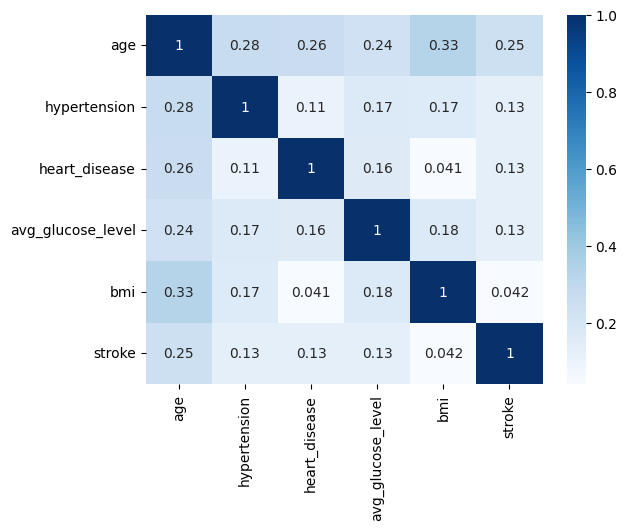

In [36]:
corr = df.corr()
sns.heatmap(data=corr, cmap='Blues', annot=True);

- The most correclated feature with the target (stroke) is age. 

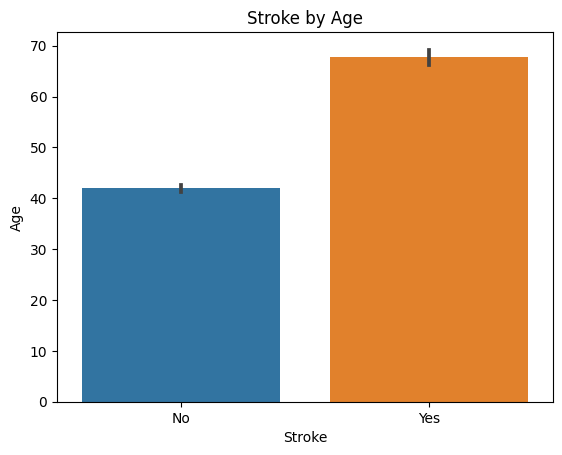

In [37]:
# barplot visual
fig, ax = plt.subplots()

sns.barplot(data=df, x='stroke', y='age')
ax.set_title('Stroke by Age')
ax.set_xlabel('Stroke')
ax.set_ylabel('Age')
plt.xticks(range(0,2), ['No', 'Yes']);

- People over 40 are more prone to having a stroke. 